# DS 6011: Read in data

- Andrew J. Graves, Cory Clayton, Joon Soh, Gabe Yohe
- 10/17/20

Here we have developed a dataset class that specifies parameters unique to each data set

In [3]:
# Dataset class that specifies file structure for different datasets
class Dataset:
    
    # Constructor assigns name, location, and size
    def __init__(self, name):
        self.name = name
        
        # Data dictionary for all datasets: directory, subjects, tasks
        data_dict = {'motormovement_imagine': 
                         {'base_dir': 'https://github.com/VIXSoh/SRM/raw/master/data/',
                          'n_subj': 109,
                          'n_task': 14
                         }
                     # Add datasets here
                    }
        # Assign attributes to dataset instance
        self.base_dir = data_dict[self.name]['base_dir']
        self.n_subj = data_dict[self.name]['n_subj']
        self.n_task = data_dict[self.name]['n_task']
    
    # Generates appropriate file paths
    def get_file_format(self, subj, task):
        
        # Checks if name follows this file structure
        if self.name in ['motormovement_imagine']:
            
            # Get all file paths
            subj_num = f"S{str(subj).rjust(3, '0')}"
            task_num = f"R{str(task).rjust(2, '0')}"
            self.file_path = f'{self.base_dir}{subj_num}/{subj_num}{task_num}.edf'
            
# Write congig for different datasets. Class ingests config

The following are helper functions for reading the data from various locations

In [47]:
# Get data from internet using wget
def wget_raw_edf(f):
    
    from wget import download
    from os import remove
    from mne.io import read_raw_edf
    
    wg = download(f) # download the data locally (temporarily)
    raw = read_raw_edf(wg, preload = True) # read data as an MNE object
    remove(wg) # delete the file locally
    return raw

# Specifies which files to iterate through
def gen_iter(param, n_params):
    
    if param != 'all': # for subset of the data
        param_iter = param
    else: # for all of the data
        param_iter = range(1, n_params+1)
    return param_iter

# Reads multiple EEG files with a single call
def read_data(dataset, subjects='all', tasks='all'):
    
    # Instantiate the data set (raw locations, number of subjects / tasks)
    data = Dataset(dataset)
    
    missing = [] # initialize missing file list
    subj_iter = gen_iter(subjects, data.n_subj) # get subject iterator
    task_iter = gen_iter(tasks, data.n_task) # get task iterator

    # Iterate through subjects
    for subj in subj_iter:
        
        # Iterate through tasks
        for task in task_iter:
            # Specify the file format
            data.get_file_format(subj, task)
            
            try: # Handles missing files
                return wget_raw_edf(data.file_path) # change back later
                # Send to preproc function next
            except:
                print(f'---\nThis file does not exist: {data.file_path}\n---')
                # Need to write the missing file list out
                missing.append(data.file_path)

Read in data

In [11]:
 = read_data('motormovement_imagine', subjects=[1], tasks=[4])

100% [..........................................................................] 2596896 / 2596896Extracting EDF parameters from C:\Users\Andrew Graves\Documents\University of Virginia\Course Work\Fall 2020\ds_6011\code\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., ...
    chs : list | 64 items (EEG: 64)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 80.0 Hz
    meas_date : tuple | 2009-08-12 16:15:00 GMT
    nchan : int | 64
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 160.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_na

## Manipulates an example subject (dated)

In [48]:
%matplotlib inline

# Import modules
import numpy as np
import mne

# Example file from example subject
raw = read_data('motormovement_imagine', subjects=[1], tasks=[4])

# Print the information
raw.info['nchan']

100% [..........................................................................] 2596896 / 2596896Extracting EDF parameters from C:\Users\Andrew Graves\Documents\University of Virginia\Course Work\Fall 2020\ds_6011\code\S001R04 (2).edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


64

In [79]:
# Create the montage
mont = mne.channels.make_standard_montage('biosemi64')
mont.ch_names = [i.upper() for i in mont.ch_names]
n_chan = len(mont.ch_names)

#raw.set_channel_types({'EXG1': 'misc', 'EXG2': 'misc',
#                       'EXG3': 'eog', 'EXG4': 'eog', 
#                       'EXG5': 'misc', 'EXG6': 'misc',
#                       'EXG7': 'misc', 'EXG8': 'misc',
#                       'Status': 'stim'})

raw.info['ch_names'] =  [i.replace('.', '').upper() for i in raw.info['ch_names'] if i not in ['T9', 'T10']]

#raw.pick_types(eeg=True)

# Set the montage
raw.set_montage(montage=mont)

RuntimeError: info channel name inconsistency detected, please notify mne-python developers

In [81]:
len(raw.info['ch_names'])

62

In [49]:
# Print the EEG data shape
shape = raw.get_data().shape
print(shape)

(64, 20000)


In [28]:
# Sampling and Nyquist frequency
samp_freq = raw.info['sfreq']
nyq = samp_freq / 2
print(nyq)

80.0


In [43]:
# Task time
shape[1] / (samp_freq)

Signature: mne.channels.make_standard_montage(kind, head_size=0.095)
Docstring:
Read a generic (built-in) montage.

Parameters
----------
kind : str
    The name of the montage to use. See notes for valid kinds.
head_size : float
    The head size (in meters) to use for spherical montages.
    Defaults to 95mm.

Returns
-------
montage : instance of DigMontage
    The montage.

See Also
--------
DigMontage
make_dig_montage
read_custom_montage

Notes
-----
Individualized (digitized) electrode positions should be read in using
:func:`read_dig_captrack`, :func:`read_dig_egi`, :func:`read_dig_fif`,
:func:`read_dig_polhemus_isotrak`, :func:`read_dig_hpts` or made with
:func:`make_dig_montage`.

Valid ``kind`` arguments are:

===================   =====================================================
Kind                  Description
===================   =====================================================
standard_1005         Electrodes are named and positioned according to the
         

In [41]:
# T0 is baseline, T1 is left fist / both, T2 if right fist / both
# Create an event dictionary
event_dict = {'baseline': 1, 'left/both': 2, 'right/both': 3}

ev = mne.events_from_annotations(raw)
print(ev[1])
np.delete(ev[0], 1, axis=1)

Used Annotations descriptions: ['T0', 'T1', 'T2']
{'T0': 1, 'T1': 2, 'T2': 3}


array([[    0,     1],
       [  672,     3],
       [ 1328,     1],
       [ 2000,     2],
       [ 2656,     1],
       [ 3328,     2],
       [ 3984,     1],
       [ 4656,     3],
       [ 5312,     1],
       [ 5984,     3],
       [ 6640,     1],
       [ 7312,     2],
       [ 7968,     1],
       [ 8640,     3],
       [ 9296,     1],
       [ 9968,     2],
       [10624,     1],
       [11296,     3],
       [11952,     1],
       [12624,     2],
       [13280,     1],
       [13952,     2],
       [14608,     1],
       [15280,     3],
       [15936,     1],
       [16608,     2],
       [17264,     1],
       [17936,     3],
       [18592,     1],
       [19264,     2]])

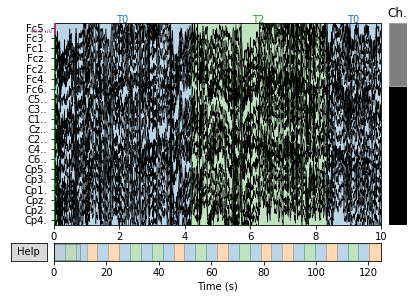

In [33]:
unfilt = raw.plot()

Setting up band-stop filter from 0.5 - 79 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 79.00 Hz: -6.02, -6.02 dB



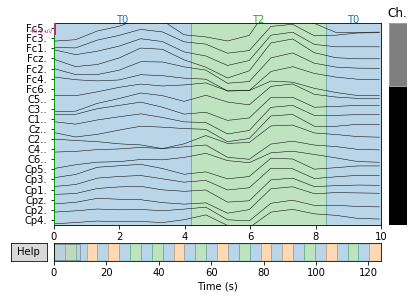

In [35]:
filt = raw.plot(highpass=nyq-1, lowpass=.5)